<a href="https://colab.research.google.com/github/abdu355/simCLR-ml701/blob/main/ml701_simCLR_Pre_trained_V1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# SimCLR with PL + Downstream

List of full videos is here:    

https://www.youtube.com/playlist?list=PLaMu-SDt_RB4k8VXiB3hOdsn0Y3GoXo1k

Pretrained simCLR2: https://console.cloud.google.com/storage/browser/simclr-checkpoints/simclrv2/pretrained?pageState=(%22StorageObjectListTable%22:(%22f%22:%22%255B%255D%22))&prefix=&forceOnObjectsSortingFiltering=false

In [ ]:
# ------- USE FOR TPU SUPPPORT ------
# %%capture
# ! pip install cloud-tpu-client==0.10 https://storage.googleapis.com/tpu-pytorch/wheels/torch_xla-1.7-cp36-cp36m-linux_x86_64.whl
# torch.tensor([10.]*10000000000) # trick to gain RAM ( doesnt work anymore...)

In [1]:
%%capture
! pip install pytorch-lightning-bolts
! pip install pytorch-lightning
! pip install wandb
! pip install lightning-flash -U
! pip install Pillow==4.0.0
! pip install PIL
! pip install image
! pip install IPython ipykernel --update
# %reload_ext autoreload
# %autoreload
# !pip install transformers~=2.11.0


In [2]:
import torch
import pytorch_lightning as pl
from pl_bolts.models.self_supervised import SimCLR
from pl_bolts.callbacks.ssl_online import SSLOnlineEvaluator
from pl_bolts.datamodules import CIFAR10DataModule
from pl_bolts.models.self_supervised.simclr.transforms import (
    SimCLREvalDataTransform, SimCLRTrainDataTransform)

from pytorch_lightning.loggers import WandbLogger

#Lightning Flash module
# from flash import Trainer
from flash import download_data
# from flash.vision import ImageClassificationData, ImageClassifier

import zipfile
import os
import pandas as pd
import numpy as np
import torch
import torchvision

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [ ]:
#explore csv
data = pd.read_csv("https://ml701.s3.me-south-1.amazonaws.com/train.csv")
data.head()

,image_id,label
0,amd (1).tif,1
1,amd (10).tif,1
2,amd (100).tif,1
3,amd (101).tif,1
4,amd (102).tif,1


In [2]:
#load data with Flash

def downloadData():
  download_data("https://ml701.s3.me-south-1.amazonaws.com/OCT_full.zip", "data/")
  download_data("https://ml701.s3.me-south-1.amazonaws.com/train.csv", "data/")
  with zipfile.ZipFile("data/OCT_full.zip","r") as zip_ref:
    zip_ref.extractall("data/oct_images_full")

downloadData()

In [45]:
#dataset
from  pl_bolts.datamodules.async_dataloader import AsynchronousLoader
from torch.utils.data import Dataset, DataLoader
from PIL import Image

class OCTDataset(Dataset):
    """ OCT Dataset """
    
    def __init__(self, root_dir, transform=None, stage=None):
       if stage: 
         csv_output = pd.read_csv(os.path.join(root_dir, "test.csv"))
         self.images_dir = os.path.join(root_dir, "test_images")
       else:
         csv_output = pd.read_csv(os.path.join(root_dir, "train.csv"))
         self.images_dir = os.path.join(root_dir, "train_images")

       self.image_urls = np.asarray(csv_output["image_id"])
       self.labels = np.asarray(csv_output["label"])
       self.transform = transform
        
    def __len__(self):
        return len(self.image_urls)
    
    def __getitem__(self, idx):
        # Get and load image
        image_path = os.path.join(self.images_dir, self.image_urls[idx])
        image = Image.open(image_path)
        # Perform transforms if any
        if self.transform:
            image = self.transform(image)
        # Get label
        label = self.labels[idx]   
        return image, label

In [47]:
#datamodule
from torch.utils.data import random_split
import math

class OCTDataModule(pl.LightningDataModule):
    """ OCT DataModule for Lightning """
    def __init__(self, root_dir, transform=None, batch_size=32):
        super().__init__()
        self.batch_size = batch_size
        self.root_dir = root_dir
        self.transform = transform
        
    def setup(self, stage=None):
        oct_full = OCTDataset(self.root_dir, self.transform)
        train_data_len = math.floor(len(oct_full) * 0.7)
        val_data_len = len(oct_full) - train_data_len
        # Create train and validation datasets
        self.oct_train, self.oct_val = random_split(oct_full, [train_data_len, val_data_len], generator=torch.Generator().manual_seed(42))
        
        # Create test dataset
        self.oct_test = OCTDataset(self.root_dir, self.transform, stage="test")

    def train_dataloader(self):
        return DataLoader(self.oct_train, batch_size=self.batch_size)
    
    def val_dataloader(self):
        return DataLoader(self.oct_val, batch_size=self.batch_size)
    
    def test_dataloader(self):
        return DataLoader(self.oct_test, batch_size=self.batch_size)

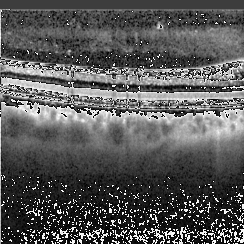

In [5]:
#transforms on OCT data
import torchvision.transforms as transforms
from pl_bolts.models.self_supervised.simclr.transforms import SimCLRTrainDataTransform
import torchvision.transforms.functional as tvf

transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize((244, 244)),
    # transforms.RandomCrop(224),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)) # Standard Normalization
    # transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)) #ImageNet Normalization
    ])
# transform = SimCLRTrainDataTransform(input_height=224,
#                                      jitter_strength=0.4,
#                                      gaussian_blur=False, 
#                                      normalize=None)

root_dir = "data/oct_images_full/"
oct_data = OCTDataModule(root_dir, transform, batch_size=64)
oct_data.setup()

ds_train = oct_data.oct_train
# ds_train[img_index][][channel]
tvf.to_pil_image(ds_train[1004][0][0])

In [26]:
# unfreeze params post warm-up.  Can be used with any model.
from pytorch_lightning.callbacks import Callback
class UnFreezeCallback(Callback): 
    def on_epoch_end(self, trainer, pl_module):
        if trainer.current_epoch == 10:
            pl_module.embeddings.unfreeze()

In [27]:
# model
#load simCLR pre-trained on imagenet
import torch.optim as optim
import torch.nn.functional as F
import torch.nn as nn
from pl_bolts.models import LinearRegression, LogisticRegression
import torchvision.models as models

class OCTModel(pl.LightningModule):
    def __init__(self, learning_rate=1e-3,freeze_base=True, tune=False):
        super().__init__()
              

        weight_path = 'https://pl-bolts-weights.s3.us-east-2.amazonaws.com/simclr/bolts_simclr_imagenet/simclr_imagenet.ckpt'
        base_model = SimCLR.load_from_checkpoint(weight_path, strict=False)
        # resnet50 = models.resnet50(pretrained=True)
        

        # Set our learning rate
        self.learning_rate = learning_rate   
        self.tune = tune

        num_target_classes = 3
        self.embeddings = base_model
        #freeze
        if freeze_base:
          self.embeddings.eval()  

        # Use the pretrained simclr model to classify oct. 
        self.classifier = nn.Linear(2048, num_target_classes)
        # self.classifier = LinearRegression(input_dim=2048, num_classes=num_target_classes)
        
        # Create loss function
        self.loss_fn = torch.nn.CrossEntropyLoss()
    
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
        return optimizer
    
    def forward(self, input_data):
        # input = input_data[0].unsqueeze(0)
        # input = input.view(64, 3, 244,244)
        representations = self.embeddings(input_data)
        preds = self.classifier(representations)
        # preds = self.classifier(representations[0])
        return preds
    
    def training_step(self, train_batch, batch_idx):
        x, y = train_batch
        predictions = self.forward(x)
        loss = self.loss_fn(predictions, y)

        if not self.tune:
          self.logger.experiment.log({"train_input_image":[wandb.Image(train_batch[0][0].cpu(), caption="train_input_image")]},commit=False)
        self.log('train_loss', loss)
        return loss
    
    def validation_step(self, val_batch, batch_idx):
        x, y = val_batch
        predictions = self.forward(x)
        loss = self.loss_fn(predictions, y)

        if not self.tune:
          self.logger.experiment.log({"val_input_image":[wandb.Image(val_batch[0][0].cpu(), caption="val_input_image")]},commit=False)
        self.log('val_loss', loss)

        


GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type             | Params
------------------------------------------------
0 | embeddings | SimCLR           | 30.0 M
1 | classifier | Linear           | 6.1 K 
2 | loss_fn    | CrossEntropyLoss | 0     
------------------------------------------------
30.0 M    Trainable params
0         Non-trainable params
30.0 M    Total params
120.103   Total estimated model params size (MB)


Restored states from the checkpoint file at /content/lr_find_temp_model.ckpt


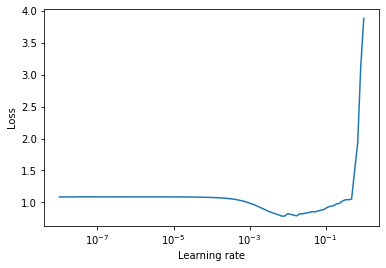

In [16]:
#init model
model = OCTModel(freeze_base=False, tune=True)

#tune
trainer = pl.Trainer(gpus=1)
lr_finder = trainer.tuner.lr_find(model,datamodule=oct_data)

# Inspect results
fig = lr_finder.plot(); fig.show()
suggested_lr = lr_finder.suggestion()


In [17]:
print(suggested_lr)

0.002754228703338169


In [28]:
# Overwrite lr and create new model
model_tuned = OCTModel(learning_rate=suggested_lr,freeze_base=True, tune=False)

In [29]:
#init logger
experiment_num = 2
experiment_name = f"exp_as_{experiment_num}_010321" 
experiment_id = '02'
project_name = "simCLR-ml701"


wandb_logger = WandbLogger(name=experiment_name,project=project_name, id=experiment_id, log_model=True)
wandb_logger.watch(model_tuned, log="all", log_freq=50)

#cp
checkpoint_callback = pl.callbacks.ModelCheckpoint(
    dirpath= experiment_name + '_ckp',
    monitor='val_loss',
    filename='{epoch}-{train_loss:.2f}-{val_loss:.2f}'    
)

# fit
trainer = pl.Trainer(max_epochs=20,progress_bar_refresh_rate=20,gpus=1,logger=wandb_logger,callbacks=[checkpoint_callback,UnFreezeCallback()])
trainer.fit(model_tuned, datamodule=oct_data)



#save checkpoint with weights
checkpoint_file = experiment_name +"_pretrained.ckpt"
trainer.save_checkpoint(checkpoint_file)
#save to W&B
trainer.logger.experiment.log_artifact(checkpoint_file, type="model")

GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type             | Params
------------------------------------------------
0 | embeddings | SimCLR           | 30.0 M
1 | classifier | Linear           | 6.1 K 
2 | loss_fn    | CrossEntropyLoss | 0     
------------------------------------------------
30.0 M    Trainable params
0         Non-trainable params
30.0 M    Total params
120.103   Total estimated model params size (MB)


wandb: WARNING Saving files without folders. If you want to preserve sub directories pass base_path to wandb.save, i.e. wandb.save("/mnt/folder/file.h5", base_path="/mnt")
wandb: WARNING Symlinked 0 file into the W&B run directory, call wandb.save again to sync new files.


In [34]:
#end run on W&B + sync results
import wandb
wandb.finish()

_step,397
_runtime,812
_timestamp,1614613284
val_loss,3e-05
epoch,19
train_loss,0.0


_runtime,▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅█
_timestamp,▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅█
_step,▁▁▂▂▂▃▃▃▃▄▄▄▄▅▅▆▆▆▆▇▇▇▇██
val_loss,▂█▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▂▂▂▂▃▃▄▄▄▄▅▅▅▆▆▆▇▇▇███
train_loss,█▆▁▁


In [56]:
root_dir = "data/oct_images_full/"
oct_data = OCTDataModule(root_dir, transform, batch_size=64)
oct_data.setup()

In [60]:
#eval
def evaluate_results(loader):
    model_tuned.eval()
    correct = 0
    total = 0
    
    with torch.no_grad():
        for x, y in iter(loader):        
            x = x.to(device)
            y = y.to(device)
            preds = model_tuned(x)
            _, predicted = torch.max(preds, 1)
            print(predicted)

            correct += (predicted == y).sum().item()
            total += len(y)
    return (correct / total)

# Check the Validation Results
# validation_loader = oct_data.val_dataloader()
# print(evaluate_results(validation_loader))

test_loader = oct_data.test_dataloader()
print(evaluate_results(test_loader))

tensor([2, 2, 2, 1, 1, 1, 2, 2, 2], device='cuda:0')
0.6666666666666666


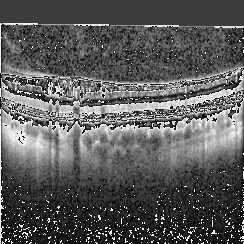

In [53]:
ds_test = oct_data.oct_test
# ds_test[0][0][0]
tvf.to_pil_image(ds_test[0][0][0])